Pepper__bell___Bacterial_spot: 997 images
Pepper__bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Tomato_Bacterial_spot: 2127 images
Tomato_Early_blight: 1000 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato__Target_Spot: 1404 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images
Tomato__Tomato_mosaic_virus: 373 images
Tomato_healthy: 1591 images


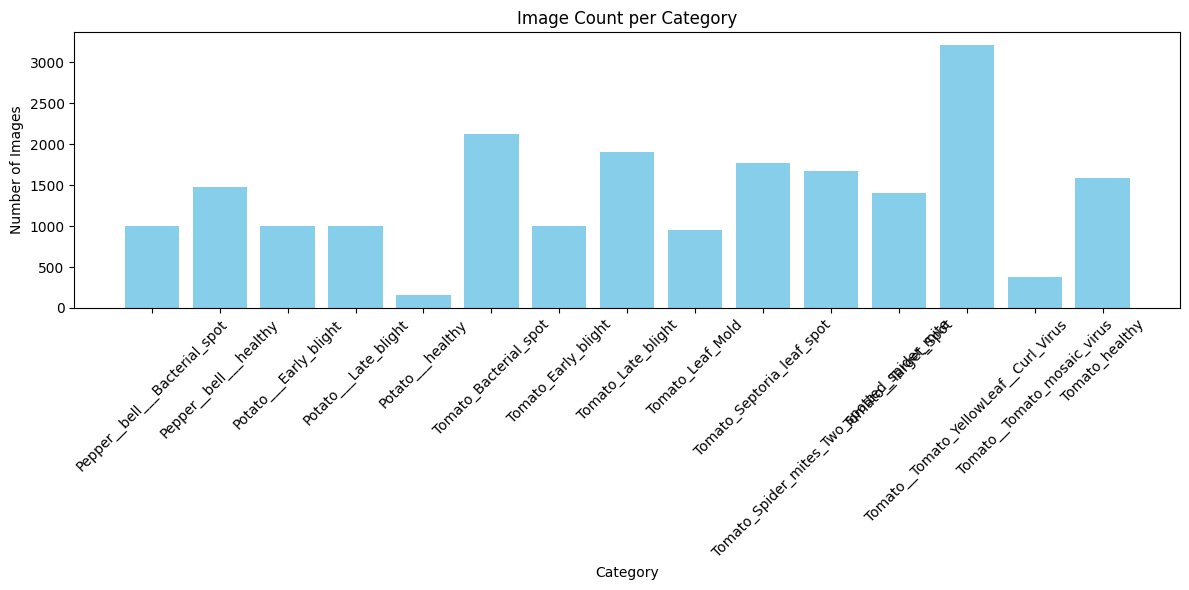

In [1]:
import os
import matplotlib.pyplot as plt

# Set dataset path
dataset_path = "/content/drive/MyDrive/NNDL /PlantVillage"

# List categories
categories = sorted(os.listdir(dataset_path))
image_counts = []

# Count images in each category
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_counts.append(len(image_files))
    print(f"{category}: {len(image_files)} images")

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(categories, image_counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Image Count per Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2]:

# Use Path object instead of string
from pathlib import Path

# Get class names (folder names)
classes = sorted(os.listdir(dataset_path))

# Initialize empty lists
images_list = []
labels_list = []

In [4]:
#Preprocessing of Image & Label List Creation
import os
import numpy as np
from PIL import Image
from pathlib import Path

# Convert dataset_path to a Path object
dataset_path = Path(dataset_path)

# Loop through each class
for index, label in enumerate(classes):
    image_folder = dataset_path / label
    for image_path in image_folder.glob("*"):
        try:
            # Load image
            image = Image.open(image_path)

            # Convert to RGB if not already
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Resize to 128x128
            image = image.resize((128, 128))

            # Convert to numpy array and append
            images_list.append(np.array(image))
            labels_list.append(index)
        except Exception as e:
            print(f"Failed to process {image_path}: {e}")

print("Total Images:", len(images_list))
print("Total Labels:", len(labels_list))

Failed to process /content/drive/MyDrive/NNDL /PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c: cannot identify image file '/content/drive/MyDrive/NNDL /PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'
Total Images: 20638
Total Labels: 20638


In [5]:
print("Type of images_list:", type(images_list))
print("Shape of image in images_list:", images_list[0].shape)
print("Type of image in images_list:", type(images_list[0]))

Type of images_list: <class 'list'>
Shape of image in images_list: (128, 128, 3)
Type of image in images_list: <class 'numpy.ndarray'>


In [6]:
#Preprocessing of Image & Label List Convertion to NumPy Arrays
images_list = np.array(images_list)
labels_list = np.array(labels_list)

In [7]:
#Split Data to Train, Test & Validation
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(images_list, labels_list, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)
print("Pixel values of the first pixel (RGB) of image (BEFORE NORMALIZATION):", X_train[0][0][0])

X_train: (14446, 128, 128, 3)
X_test: (3096, 128, 128, 3)
X_val: (3096, 128, 128, 3)
Pixel values of the first pixel (RGB) of image (BEFORE NORMALIZATION): [172 152 146]


In [9]:
# Data Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0
print("Pixel values of the first pixel (RGB) of image (AFTER NORMALIZATION):", X_train[0][0][0])

Pixel values of the first pixel (RGB) of image (AFTER NORMALIZATION): [0.6745098  0.59607843 0.57254902]


In [12]:
#Train Augmentations & Train Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a generator to pass the data in batches with the augmentations
train_augmentations = ImageDataGenerator(
    # Rotation from -30 to +30 degrees
    rotation_range=0.4,
    # Shear by 20%
    shear_range=0.2,
    # Shift horizontally by 10%
    width_shift_range=0.1,
    # Shift vertically by 10%
    height_shift_range=0.1,
    # Flip horizontally
    horizontal_flip=True,
    # Fill new pixels with nearest existing pixel to not lose pixels
    fill_mode='nearest')

# Create a generator to pass the data in batches with the augmentations
train_generator = train_augmentations.flow(
    X_train,
    y_train,
    # 32 images will be passed at a time
    batch_size=32)

In [13]:
# Test Augmentations & Test Generator
test_augmentations = ImageDataGenerator()

# Create a generator to pass the data in batches with the augmentations
test_generator = test_augmentations.flow(
    X_test,
    y_test,
    batch_size=32)

(128, 128, 3)


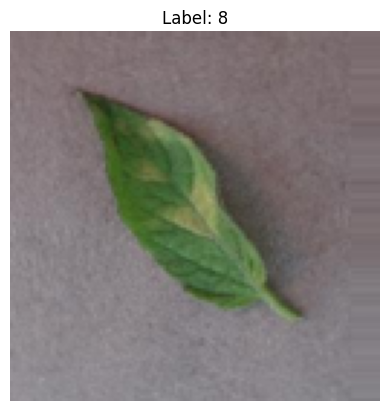

In [14]:

#Plot Image from Train Generator

images_batch, labels_batch = next(train_generator)
# Take the first image from the batch
image_to_preview = images_batch[0]

print(image_to_preview.shape)
# Display the image
plt.imshow(image_to_preview)
plt.title(f"Label: {labels_batch[0]}")
plt.axis('off')
plt.show()

In [16]:
#Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

In [19]:
import keras
input_shape = X_train.shape[1:]
dropout_rate = 0.3

model = keras.models.Sequential([
    # Input layer
    # 32 filters, 3x3 filter size, "same" padding, ReLU activation function, input shape of the images
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=input_shape),
    # MaxPooling layer
    # Max pooling operation with a 2x2 pool size, reducing spatial dimensions by half
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional layer
    # 64 filters, 3x3 filter size, "same" padding, ReLU activation function
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    # MaxPooling layer
    # Max pooling operation with a 2x2 pool size, reducing spatial dimensions by half
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional layer
    # 128 filters, 3x3 filter size, "same" padding, ReLU activation function
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
    # MaxPooling layer
    # Max pooling operation with a 2x2 pool size, reducing spatial dimensions by half
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten layer
    # Converts the 2D matrix into a 1D vector.
    # Essential before feeding data into fully connected layers
    keras.layers.Flatten(),

    # First Dense layer
    # Fully connected layer with 256 neurons, ReLU activation function
    keras.layers.Dense(units=256, activation="relu"),

    # Dropout layer
    # Dropout rate of 30% to prevent overfitting by randomly setting 30% of input units to 0
    keras.layers.Dropout(dropout_rate),

    # Output layer
    # 11 neurons, corresponding to the number of classes
    # Softmax ensures sum of probabilities is 1
    keras.layers.Dense(units=15, activation="softmax")
])

# Summary of the model
model.summary()

# Adam optimizer, Loss function for multi-class classification
model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,485,967 (32.37 MB)

 Trainable params: 8,485,967 (32.37 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, lr_scheduler]
                       )

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.4319 - loss: 1.7800 - val_accuracy: 0.7687 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - accuracy: 0.7849 - loss: 0.6428 - val_accuracy: 0.8488 - val_loss: 0.4929 - learning_rate: 0.0010
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.8521 - loss: 0.4298 - val_accuracy: 0.8889 - val_loss: 0.3393 - learning_rate: 0.0010
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - accuracy: 0.9098 - loss: 0.2727 - val_accuracy: 0.8601 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.9115 - loss: 0.2604 - val_accuracy: 0.8976 - val_loss: 0.3425 - learning_rate: 0.0010
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.9421 - loss: 0.1681 - val_accuracy: 0.9018 - val_loss: 0.3381 - learning_rate: 0.0010
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.9507 - loss: 0.

In [22]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the classes for the test set
y_pred = model.predict(X_test)

# Get the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(y_test, y_pred_classes))


97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       146
           1       0.93      0.98      0.95       235
           2       0.93      0.97      0.95       175
           3       0.93      0.88      0.90       155
           4       0.86      0.78      0.82        23
           5       0.98      0.96      0.97       311
           6       0.87      0.77      0.82       144
           7       0.89      0.93      0.91       297
           8       0.91      0.91      0.91       139
           9       0.91      0.87      0.89       243
          10       0.95      0.86      0.90       236
          11       0.87      0.91      0.89       219
          12       0.94      0.99      0.97       484
          13       1.00      0.92      0.96        51
          14       0.91      1.00      0.95       238

    accuracy                           0.92      3096
   macro avg       0.92      0.90     

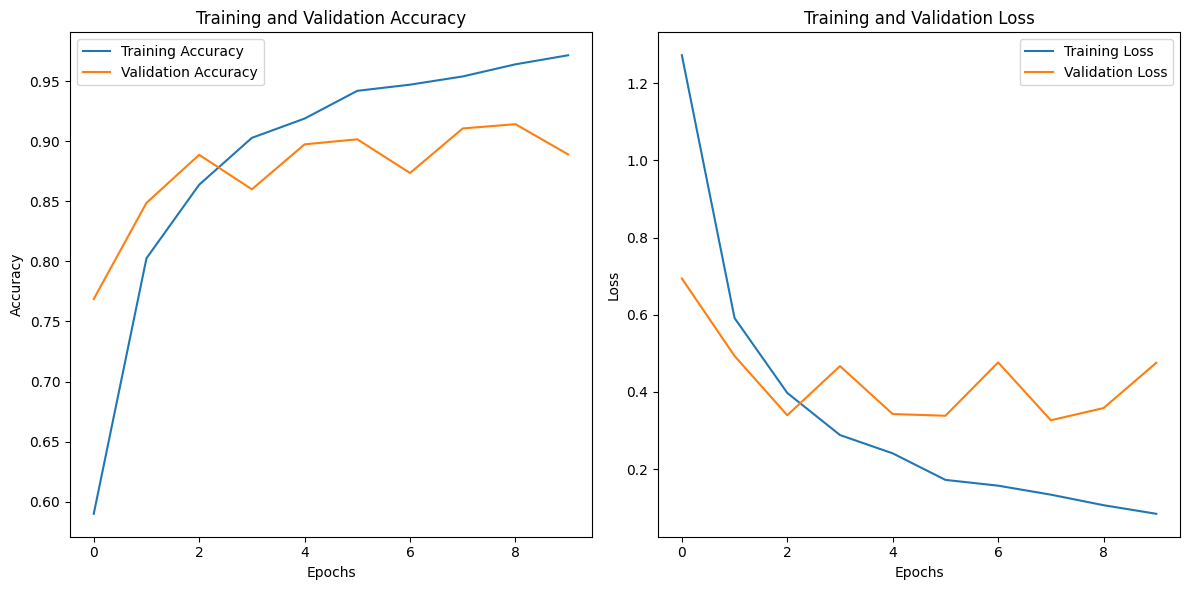

In [23]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.9271 - loss: 0.2336
Test Loss: 0.26416265964508057
Test Accuracy: 0.9244186282157898


97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step


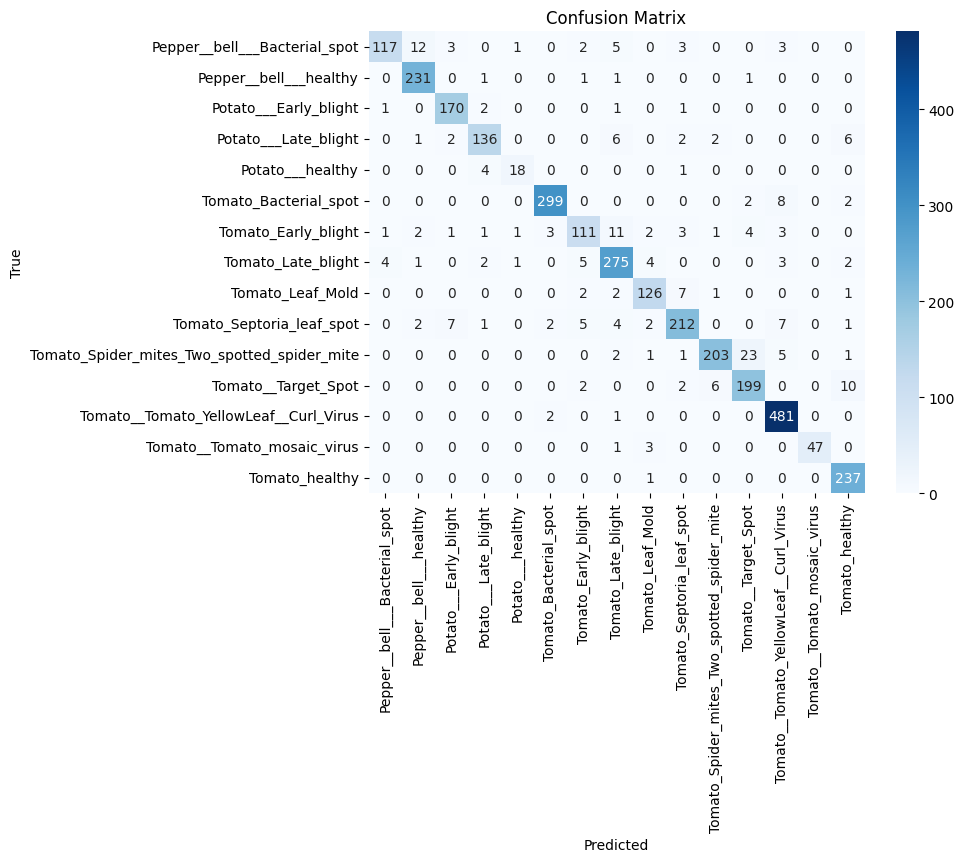

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict classes for test data
y_pred_classes = np.argmax(model.predict(X_test), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()